# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* deal w/ zeroing info
* determine how tyler stored waveforms
* iterating w/ spykes 
* plotting iterations
* grab sending trial num and prepare next trail and add to df
* adjust loading function to be separate for beh/spks 


## Libs & fxs

In [3]:
# settings

%load_ext autoreload
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import os
from spykes.spykes.plot.neurovis import NeuroVis
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I/O & Wrangle

In [5]:
# global
dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_name = 'data_sdc_20190902_145404_fromSD'

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict, "20190902")

"Loading & saving info for later"
# # beh_df.to_csv(os.path.join(dir_name, sess_name, 'beh_df.csv'), index=False)
# # preloading spks_dict
# import pickle

# f = open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'),"wb")
# pickle.dump(spks_dict,f)
# f.close()

# f= open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'), "rb")
# loaded_dictionary = pickle.load(f)

'Loading & saving info for later'

# Plotting 2 second, L hit trials

In [6]:
"get_raster for all neurons and assigned events"

def get_neuron_rasters(neurons, events, windows, df):
    """
    This function can be used to get rasters for multiple neurons across multiple events
    with specific time windows for each event
    
    inputs:
    -------
    neurons : NeuroVis object, N neurons long
    events  : list, event name in strings from your behavior df you want to align to
    windows : list, time window in ms to grab for each event
    df      : behavior data frame with event information
    
    returns:
    -------
    neuron_rasters : list, raster dictionaries stored by [neuron][event] for plotting"""
    
    #initialize storage ([Neuron][Event])
    neuron_rasters = []  

    # iterate over each neuron and event
    for neuron in range(len(neurons)):
        
        rasters = []
        
        for event in range(len(events)):
            
        # create raster dictionary
            raster = neurons[neuron].get_raster(event = events[event], conditions=None, 
                                                df = df, window=windows[event], plot=False)
            rasters.append(raster)

        neuron_rasters.append(rasters)
    
    return neuron_rasters



In [7]:
# filter dataframe
beh_df_d2_hl = beh_df[(beh_df['correct_side'] == 'LEFT') & (beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]


# initilaize
events = ['c_poke', 'aud1_on', 'aud2_on', 'hit_state', 'aud1_on']
windows = [[-300,700], [-500,1000], [-500, 1000], [-500,1100], [-1000,2300]]

# create
neuron_rasters = get_neuron_rasters(neurons, events, windows, df=beh_df_d2_hl)

In [8]:
def get_neuron_psths(neurons, events, windows, df):
    """
    This function can be used to get psths for multiple neurons across multiple events
    with specific time windows for each event
    
    inputs:
    -------
    neurons    : NeuroVis object, N neurons long
    events     : list, event name in strings from behavior df you want to align to
    df         : behavior data frame with event information
    conditions : str, condition namefrom behavior df to split by (e.g. hit Y/N)
    windows    : list, time window in ms to grab for each event
    binsize    : int, binsize in ms 
     
    returns:
    -------
    neuron_psths : list, psths dicts stored by [neuron][event] for plotting"""
    
    
    #initialize storage ([Neuron][Event])
    neuron_psths = []  

    # iterate over each neuron and event
    for neuron in range(len(neurons)):
        
        psths = []
        
        for event in range(len(events)):
            
        # create psth dictionary
        
            psth = neurons[neuron].get_psth(event=events[event], df=beh_df_d2_hl,
                          window=windows[event], binsize=50, plot=False,
                          event_name=events[event])
            
            psths.append(psth)

        neuron_psths.append(psths)
    
    return neuron_psths
    

In [9]:
neuron_psths = get_neuron_psths(neurons, events, windows, df=beh_df_d2_hl)

[autoreload of spykes.spykes.plot.neurovis failed: Traceback (most recent call last):
  File "c:\users\brodylab\anaconda3\envs\pwmephys\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\brodylab\anaconda3\envs\pwmephys\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\users\brodylab\anaconda3\envs\pwmephys\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\users\brodylab\anaconda3\envs\pwmephys\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call

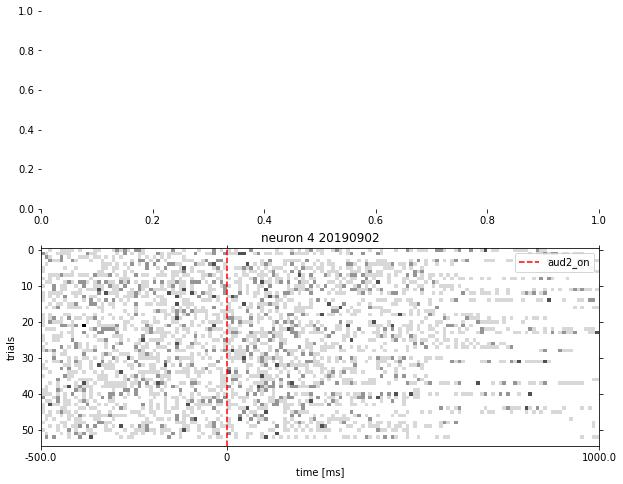

In [39]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

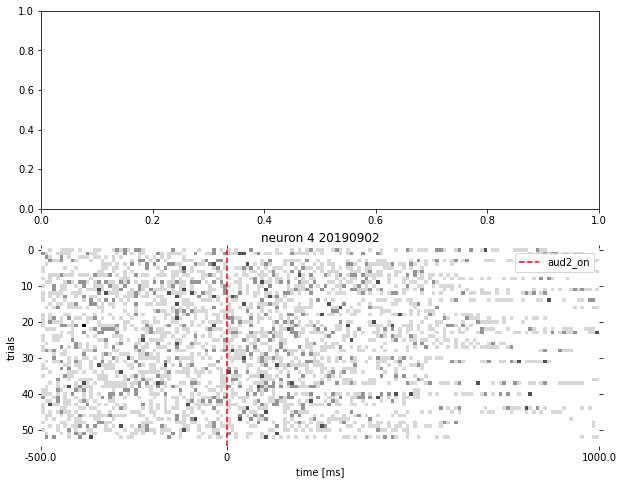

In [36]:


fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[1], event_name=events[cc], cmap="Greys")

In [ ]:
# next steps: change the spykes documentation to take ax as an argument and try to
# plot all the conditions for 1 neuron on the same axis. also edit plot title

# then, work on creating the same type of function for psth & try to plot all psths together with modified code

# then, try and plot them all together

## Rouge plots

In [ ]:
"proof of cell"

# need to f/u w/ Tyler on these shapes

tt_num = 3
wave_snippet = spks_dict['waves_mn']
plt.plot(wave_snippet[tt_num][tt_num])

In [ ]:
n_cells = len(spks_dict["event_ts_fsm"])
trode_num = spks_dict["trodenum"]
spk_qual = []
for cell in range(n_cells):
    if spks_dict["mua"][cell] == 1:
        spk_qual.append("multi")
    elif spks_dict["single"][cell] == 1:
        spk_qual.append("single")
    else:
        raise TypeError("cell not marked as multi or single")
n_cells, spk_qual, trode_num        

In [ ]:
plt.style.use('seaborn-ticks')
conditions = 'response' #either L lick or R lick
cmap = [plt.get_cmap('Blues'), plt.get_cmap('Reds')]
colors = ['#E82F3A', '#3B439A']


# get rasters------------------------------------------------------
rasters_fig2b1 = neuron.get_raster(event=event,
                                   conditions=conditions,
                                   df=trials_df,
                                   window=window,
                                   binsize=20,
                                   plot=False)


plt.figure(figsize=(8, 10))
cond_ids = rasters_fig2b1['data'].keys()[::-1]

# plot rasters-------------------------------------------------------
for i, cond_id in enumerate(cond_ids):
    plt.subplot(4, 1, i + 1)
    neuron.plot_raster(rasters=rasters_fig2b1,
                       cond_id=cond_id,
                       cmap=cmap[i],
                       sortby=None,
                       has_title=False)
    plt.xlabel('')


# plot psth-------------------------------------------------------
plt.subplot(212)
psth = neuron.get_psth(event=event,
                       conditions=conditions,
                       df=trials_df,
                       window=window,
                       binsize=100,
                       plot=True,
                       colors=colors)
plt.title('')
plt.show()

In [ ]:
#these subplots are possesed idk
events = ['c_poke', 'aud1_on', 'aud2_on', 'hit_state']
nn = 1
plt.style.use('seaborn-ticks')
plt.figure(figsize=(8,20))

raster0 = neurons[nn].get_raster(event = events[0],
          conditions=None, df = beh_df_d2_hl,
          plot=False)

plt.subplot(4,1,1)
neurons[nn].plot_raster(raster0, cond_name='c_poke', cmap='Blues',has_title=True)


psth0 = neurons[nn].get_psth(event=events[0], conditions=None,
                           df=beh_df_d2_hl, window = [-100,500],
                           binsize = 50, plot=False)

plt.subplot(211)
neurons[nn].plot_psth(psth0)

plt.subplot(212)

plt.show()

In [ ]:
event = 'aud2_on'
condition = 'delay'
window = [-1000, 1500]
binsize = 50
neuron_number = 1
neuron = neuronL[neuron_number - 1]

plt.figure(figsize=(10, 5))
psth = neuron.get_psth(event = event,
                       conditions = condition,
                       df = beh_df,
                       window = window,
                       binsize = binsize,
                       event_name = 'Center Poke')